In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import random
import os

In [2]:
# Taken from A3.py file found on the Computer Vision canvas files page

def minbbox(element):
    """
    Takes in a binary mask and returns a minimal bounding box around
    the non-zero elements.
    Input:
    - mask: a mask image (should contain only 0 and non-zero elements)
    Returns:
    - bbox: a list of four points in the form: [min_x, min_y, max_x, max_y]
    """

    vals = np.nonzero(element)
    min_h = vals[0].min()
    max_h = vals[0].max()
    min_w = vals[1].min()
    max_w = vals[1].max()

    return [min_w, min_h, max_w, max_h]

In [3]:
offset = 300

In [ ]:
# img_fn is a list of file paths corresponding to a scene captured at varying exposure levels
# exposure levels corresponding to the current set of images can be found in Exposureinfo.txt
img_fn = ["data/8/img-1.tif", "data/8/img-2.tif", "data/8/img-3.tif", "data/8/img-4.tif", "data/8/img-5.tif", "data/8/img-6.tif", "data/8/img-7.tif", "data/8/img-8.tif", "data/8/img-9.tif"]
exposure_times = np.array([(1/8000), (1/4000), (1/2000), (1/1000), (1/400), (1/200), (1/250),(1/500), (1/125), (1/60), (1/30), (1/15), (1/6)], dtype=np.float32)

img_list = [cv.imread(fn) for fn in img_fn]
log_exposure = [np.log(x) for x in exposure_times]

### Register images

In [8]:
# Convert all images in img_list from RGB to grayscale
gray = [cv.cvtColor(img, cv.COLOR_RGB2GRAY) for img in img_list]

# Normalize all gray scale images using histogram equalization
norm = [cv.equalizeHist(test) for test in gray]

# Use the first normalized image as the reference image for alignment
img1 = norm[0]

# Initalize the output list with the first image (unaltered)
output = [img_list[0]]

# Loop through the rest of the normalized images to align them to the reference image
for i in range(1, len(norm)):
    print(i) # Printing the current image index
    img2 = norm[i] # Storing the current normalized image in img2

    # Create an instance of the AKAZE feature detector
    detector = cv.AKAZE_create()

    # Detecting and computing keypoints for the reference and current images
    kp1, des1 = detector.detectAndCompute(img1, None) # Reference image key points
    kp2, des2 = detector.detectAndCompute(img2, None) # Current image key points

    # Brute force matching the detected keypoints between the reference and current image key points
    bf = cv.BFMatcher(cv.NORM_HAMMING, crossCheck = True)
    matches = bf.match(des1, des2)

    # Storing the matched key points (sorted based on distance)
    matches = sorted(matches, key = lambda x: x.distance)

    # Keeping the top 75% of matches or at least 10 matches
    num_good_matches = int(len(matches) * 0.75)
    matches = matches[:max(num_good_matches, 10)]

    # Getting the coordinates corresponding to the matches from both images
    pts1 = np.float32([kp1[m.queryIdx].pt for m in matches]).reshape(-1, 2)
    pts2 = np.float32([kp2[m.trainIdx].pt for m in matches]).reshape(-1, 2)

    # Compute the transofrmation matrix
    transformation_matrix, inliers = cv.findHomography(
                pts2, pts1, method=cv.RANSAC, ransacReprojThreshold=3.0, confidence=0.99
            )

    # Warping the current image to align with the reference image via the transformation matrix
    aligned_img = cv.warpPerspective(
                img_list[i], 
                transformation_matrix, 
                (img1.shape[1], img1.shape[0]),
                flags=cv.INTER_LINEAR
            )
    # Add the aligned image to output
    output += [aligned_img]


1
2
3
4
5
6
7
8
9
10
11
12


In [9]:
masks = []

# Loop through each of the aligned images
for img in output:
    minw, minh, maxw, maxh = minbbox(img) # Get the minimum bounding box for each aligned image
    h, w, _ = img.shape
    mask = np.zeros((h,w), dtype='uint8')

    # Fill the mask based on the dimensions of the minimum bounding box
    mask[minh:maxh, minw:maxw] = np.ones(((maxh-minh), (maxw-minw)), dtype='uint8')
    masks += [mask]

# The first mask is the reference since it acted as the reference image during the alignment process
joined = masks[0]
for mask in masks[1:]:
    # Updating the composite mask with each iteration using a element wise logical and
    joined = np.logical_and(joined, mask)
minw, minh, maxw, maxh = minbbox(joined)

# Shrinking the image with the hyperparameter "offset" to remove any residuals
minw = minw + int(offset / 2)
maxw = maxw - int(offset / 2)
minh = minh + int(offset / 2)
maxh = maxh - int(offset / 2)

cropped = []

# Cropping and saving each of the aligned images
for el in output:
    cropped += [el[minh:maxh, minw:maxw]]

In [10]:
num_samples = 100

samples = [(random.randint(0, cropped[0].shape[0]), random.randint(0, cropped[0].shape[1])) for _ in range(num_samples)]

# Splitting the three channels into seperate color channels
red = [img[:,:,0] for img in cropped]
green = [img[:,:,1] for img in cropped]
blue = [img[:,:,2] for img in cropped]

In [11]:
# Initializing arrays to hold the sampled red channel values
redsample = np.zeros((num_samples, len(cropped)))
for j in range(len(cropped)):
    for i in range(len(samples)):
        redsample[i,j] = red[j][samples[i][0], samples[i][1]]

# Initializing arrays to hold the sampled green channel values
greensample = np.zeros((num_samples, len(cropped)))
for j in range(len(cropped)):
    for i in range(len(samples)):
        greensample[i,j] = green[j][samples[i][0], samples[i][1]]

# Initializing arrays to hold the sampled blue channel values
bluesample = np.zeros((num_samples, len(cropped)))
for j in range(len(cropped)):
    for i in range(len(samples)):
        bluesample[i,j] = blue[j][samples[i][0], samples[i][1]]

In [12]:
def gsolve(Z, B, l, w, midval):
    """
    - Z: array of pixel values, Z[i,j] is the pixel value at location i in image j
    - B: array of log delta t (shutter speeds), B[j] for image j
    - l: lambda, the constant that determines the amount of smoothness
    - w: weighting function or array, w[z] gives the weight for pixel value z
    """
    n = 256
    

    A = np.zeros((Z.shape[0] * Z.shape[1] + n + 1, n + Z.shape[0]))
    b = np.zeros((A.shape[0], 1))
    

    k = 0 
    for i in range(Z.shape[0]):
        for j in range(Z.shape[1]):
            z_val = Z[i, j]
            wij = w(z_val)
            A[k, int(z_val)] = wij
            A[k, n + i] = -wij
            b[k, 0] = wij * B[j]  
            k += 1
    

    A[k, midval] = 1  # Middle value for 0-indexed array (256/2)
    k += 1
    
    for i in range(n - 2):

        wval = w(i + 1)

        
        A[k, i] = l * wval
        A[k, i + 1] = -2 * l * wval
        A[k, i + 2] = l * wval
        k += 1
    
    x = np.linalg.lstsq(A, b, rcond=None)[0]

    g = x[:n].flatten()
    lE = x[n:].flatten()
    
    return g, lE

In [13]:
def weight_function(z, z_min=0, z_max=255):
    """
    Implements the triangular weighting function as described in the equation:
    
    w(z) = {
        z - z_min       for z <= (z_min + z_max)/2
        z_max - z       for z > (z_min + z_max)/2
    }

    """
    mid_point = 0.5 * (z_min + z_max)
    
    if np.isscalar(z):
        if z <= mid_point:
            return z - z_min
        else:
            return z_max - z
    else:
        z = np.asarray(z)
        weights = np.zeros_like(z, dtype=float)
        
        mask_lower = z <= mid_point
        weights[mask_lower] = z[mask_lower] - z_min
        
        mask_upper = z > mid_point
        weights[mask_upper] = z_max - z[mask_upper]
        
        return weights


In [14]:
def create_radiance_map(images, g, exposure_times, weights):
    radiance_map = np.zeros(images[0].shape)

    for i in range(radiance_map.shape[0]):
        if i % 100 == 0:
            print(str(i) + " of " + str(radiance_map.shape[0]))
        for j in range(radiance_map.shape[1]):
            pixel_values = [images[k][i,j] for k in range(len(images))]
            
            # Equation 6
            numerator = 0
            denominator = 0
            for k in range(len(images)):
                w = weights(pixel_values[k])
                numerator += w * (g[pixel_values[k]] - exposure_times[k])
                denominator += w
            
            # Compute log radiance
            if denominator > 0:
                radiance_map[i,j] = numerator / denominator
            else:
                radiance_map[i,j] = g[pixel_values[0]] - exposure_times[0]
    
    # Convert from log space to linear space
    radiance_map = np.exp(radiance_map)
    return radiance_map

In [15]:
(rg, _) = gsolve(redsample, log_exposure,40, weight_function, 160)
(gg, _) = gsolve(greensample, log_exposure,40, weight_function, 160)
(bg, _) = gsolve(bluesample, log_exposure,40, weight_function, 160)

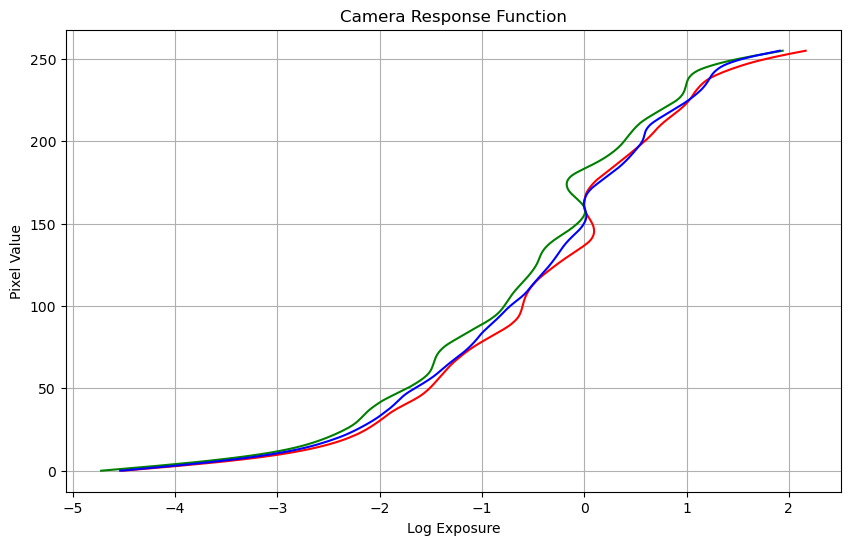

In [16]:
# Visualizing the camera response function
plt.figure(figsize=(10, 6))
plt.plot(rg, range(256), color = "red")
plt.plot(gg, range(256), color = "green")
plt.plot(bg, range(256), color = "blue")
plt.ylabel('Pixel Value')
plt.xlabel('Log Exposure')
plt.title('Camera Response Function')
plt.grid(True)
plt.show()

In [14]:
rr = create_radiance_map(red, rg, log_exposure, weight_function)
gr = create_radiance_map(green, gg, log_exposure, weight_function)
br = create_radiance_map(blue, bg, log_exposure, weight_function)

0 of 3681
100 of 3681
200 of 3681
300 of 3681
400 of 3681
500 of 3681
600 of 3681
700 of 3681
800 of 3681
900 of 3681
1000 of 3681
1100 of 3681
1200 of 3681
1300 of 3681
1400 of 3681
1500 of 3681
1600 of 3681
1700 of 3681
1800 of 3681
1900 of 3681
2000 of 3681
2100 of 3681
2200 of 3681
2300 of 3681
2400 of 3681
2500 of 3681
2600 of 3681
2700 of 3681
2800 of 3681
2900 of 3681
3000 of 3681
3100 of 3681
3200 of 3681
3300 of 3681
3400 of 3681
3500 of 3681
3600 of 3681
0 of 3681
100 of 3681
200 of 3681
300 of 3681
400 of 3681
500 of 3681
600 of 3681
700 of 3681
800 of 3681
900 of 3681
1000 of 3681
1100 of 3681
1200 of 3681
1300 of 3681
1400 of 3681
1500 of 3681
1600 of 3681
1700 of 3681
1800 of 3681
1900 of 3681
2000 of 3681
2100 of 3681
2200 of 3681
2300 of 3681
2400 of 3681
2500 of 3681
2600 of 3681
2700 of 3681
2800 of 3681
2900 of 3681
3000 of 3681
3100 of 3681
3200 of 3681
3300 of 3681
3400 of 3681
3500 of 3681
3600 of 3681
0 of 3681
100 of 3681
200 of 3681
300 of 3681
400 of 3681
500 

In [15]:
# reinhard tonemapping function adapted from https://github.com/deepankarc/hdr-imaging/tree/master

def reinhard_tonemap(radiance_map, gamma=1/2.2, alpha=0.25):
    # tone mapping parameters
    E_map = np.zeros_like(radiance_map)

    # normalize radiance_map map for each channel
    for ch in range(3):
        map_channel = radiance_map[:,:,ch]
        E_map[:,:,ch] = (map_channel - np.min(map_channel)) / (np.max(map_channel) - np.min(map_channel))

    # gamma correction
    E_map = E_map**gamma

    # convert to grayscale and apply Reinhart Tone Mapping
    L = cv.cvtColor(E_map.astype('float32'), cv.COLOR_RGB2GRAY)
    L_avg = np.exp(np.mean(np.log(L))) # average normalized grayscale radiance (Equation 1)
    T = alpha / L_avg * L # Equation 2
    L_tone = T * (1 + (T / (T.max())**2)) / (1 + T) # Equation 4
    M = L_tone / L # Ratio between the tone mapping and original normalized map

    # scale each channel
    tonemapped_img = np.empty_like(E_map)
    for ch in range(3):
        tonemapped_img[:,:,ch] = E_map[:,:,ch] * M

    tonemapped_img = np.clip(tonemapped_img, 0.0, 1.0)
    return (tonemapped_img * 255).astype(np.uint8)

In [16]:
r_test = np.zeros((rr.shape[0], rr.shape[1], 3))
r_test[:,:,0] = rr
r_test[:,:,1] = gr
r_test[:,:,2] = br

reinhard_out = reinhard_tonemap(r_test, 1/1.4, 0.8)

In [21]:
# Load an image
img = reinhard_out
gray = cv.cvtColor(img, cv.COLOR_RGB2GRAY)

white_threshold=0.7
scale_factor=0.34
blur_strength=1001

# Normalize the image to range [0, 1]
normalized_image = img / 255.0
gray = gray / 255.0
# Define a threshold for "white" (close to 1 for all RGB channels)
# white_mask = np.any(normalized_image > white_threshold, axis=-1)
white_mask = gray > white_threshold

# Scale up the "white" regions
# bloom_mask = normalized_image * white_mask[..., np.newaxis] * scale_factor
bloom_mask =  white_mask * scale_factor

# Apply Gaussian blur to simulate glow
bloom_mask = cv.GaussianBlur(bloom_mask, (blur_strength, blur_strength), 0)

# Dilating the bloom mask after the Gaussian blur
kern = cv.getStructuringElement(cv.MORPH_ELLIPSE, (5,5))
bloom_mask = cv.dilate(bloom_mask, kern, iterations=2)

cv.imwrite("bloom_mask.jpg", (bloom_mask * 255).astype(np.uint8))


# Merge the bloom effect with the original image
result = np.clip(normalized_image + bloom_mask[...,np.newaxis], 0, 1)

# Convert back to 8-bit image
result = (result * 255).astype(np.uint8)


cv.imwrite("gray_rein_bloomed_image.jpg", result)

True

In [22]:
cv.imwrite("balance.jpg",((result * (result.mean() / result.mean(axis=(0, 1))))
            .clip(0, 255).astype(int)))

True